# Initialization Cells

## Google Colab specific initialization cell
#For those users running this on google colab, this cell can be
#turned into a code cell and run. It will have colab install needed packages and,
#most importantly, it will clone the 'dataFiles' folder of this repository
#so that you can access it here.
#Use ctrl+m+y to convert to code cell in google colab

!apt-get install subversion
!svn checkout https://github.com/wesleymsmith/lipidMapVisualization/trunk/dataFiles

In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import collections
import sys
import gc
import os
import sklearn as skl
from sklearn import decomposition
from sklearn import metrics
from sklearn import discriminant_analysis
from sklearn import cluster
import tqdm
import ipywidgets
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Intro

This notebook uses the lipid center of mass coordinate data generated by the 
'extract_membrane_headgroups.ipynb' notebook to predict which leaflet each lipid resdiue
belonged too. The resulting data will be used to construct height and density maps for
individual leaflets.

Since the data files are too large to store as single files on github, we will use the
functions defined in 'extract_membrane_headgroups.ipynb' to load and save datafiles piecewise

# Load Data 
be sure to run the appropriate cell at the top if you are using google colab

In [2]:
def saveArrayChunks(pathBase,arr,nChunks,axis=0,
                    pbar=None):
    """
        pathBase: the prefix of the file path to save each chunk to.
                    files will be named pathBase.chunk_#.npy, where # is
                    a zero padded integer (to make loading, sorting, etc easier)
        arr: the array to be saved
        axis: the axis along which to split the array ()
    """
    arrayChunks=np.array_split(arr,nChunks,axis=axis)
    ndigits=int(np.ceil(np.log10(nChunks)))
    digitStr='%'+'0%g'%ndigits+'g'
    if not pbar is None:
        pbar.n=len(arrayChunks)
        pbar.refresh()
    for iChunk,arrayChunk in enumerate(arrayChunks):
        outPath='.'.join([pathBase,'chunk_%s'%(digitStr%iChunk),'npy'])
        np.save(outPath,arrayChunk)
        if not pbar is None:
            pbar.update()
            
def loadArrayChunks(pathBase,nChunks,axis=0,
                    pbar=None):
    arrayChunks=[]
    ndigits=int(np.ceil(np.log10(nChunks)))
    digitStr='%'+'0%g'%ndigits+'g'
    if not pbar is None:
        pbar.n=len(arrayChunks)
        pbar.refresh()
    for iChunk in np.arange(nChunks):
        dataPath='.'.join([pathBase,'chunk_%s'%(digitStr%iChunk),'npy'])
        arrayChunks.append(np.load(dataPath))
        if not pbar is None:
            pbar.update()
    return np.concatenate(arrayChunks,axis=axis)

Now we can load the center of mass data set for each system.

In [8]:
dataFileDir='dataFiles'
comDataDir='/'.join([dataFileDir,'headgroupCoords'])
leafletClusteringDir='/'.join([dataFileDir,'leafletClustering'])

comFileTypeName='headgroup_COM_coords'

systems=['POPC','POPS','PIP2']

nChunks=4

comDataDict={}
print 'Loading data sets ',
with tqdm.tqdm_notebook() as pbar:
    for system in systems:
        print system,
        pbar.set_description_str(system)
        comFileNameBase='.'.join([system,comFileTypeName])
        comFilePathBase='/'.join([comDataDir,comFileNameBase])
        comDataDict[system]=loadArrayChunks(comFilePathBase,nChunks=nChunks,axis=1,
                                            pbar=pbar)
        gc.collect()
    print ''
print 'done loading data'
print '--- --- --- ---'

for setKey in comDataDict:
    print setKey,
    print comDataDict[setKey].shape

Loading data sets 

 POPC POPS PIP2 

done loading data
--- --- ---
POPC (1176, 2001, 3)
POPS (1282, 1592, 3)
PIP2 (1290, 1592, 3)


# Visualize raw headgroup center data
We now have the center of mass data for each system. Before diving straight into clustering,
lets have a look at them visually.

In [21]:
systemWidget=widgets.Dropdown(
                 options=comDataDict.keys(),
                 description='System: ')
frameWidget=widgets.IntSlider(description='Frame:',
                              continuous_update=False)

def updateFrameRange(*args):
    frameRange=[0,comDataDict[systemWidget.value].shape[1]-1]
    frameWidget.min=frameRange[0]
    frameWidget.max=frameRange[1]
    frameWidget.value=np.clip(frameWidget.value,
                              frameRange[0],
                              frameRange[1])
frameWidget.observe(updateFrameRange)

def plotGrids(systemName,frameNumber):
    frame=np.clip(
            frameNumber,
            0,
            comDataDict[systemName].shape[1]-1)
    comData=comDataDict[systemName][
        :,
        frame,
        :]
    fig,axs=plt.subplots(1,3)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    
    ax=axs.flat[0]
    ax.scatter(comData[:,0],comData[:,1])
    ax.set_title('%s: XY, frame %g'%(systemName,frame))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    ax=axs.flat[1]
    ax.scatter(comData[:,0],comData[:,2])
    ax.set_title('%s: XZ, frame %g'%(systemName,frame))
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    
    ax=axs.flat[2]
    ax.scatter(comData[:,1],comData[:,2])
    ax.set_title('%s: YZ, frame %g'%(systemName,frame))
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    
    plt.tight_layout()
    plt.show()
    
interact(plotGrids,
         systemName=systemWidget,
         frameNumber=frameWidget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU3lzdGVtOiAnLCBvcHRpb25zPSgnUE9QQycsICdQT1BTJywgJ1BJUDInKSwgdmFsdWU9J1BPUEMnKSwgSW50U2zigKY=


<function __main__.plotGrids>

# Clustering via DBSCAN

For the most part the leaflets appear to have a decent separation based on these phosphate group center of mass coordinates. We will now run DBSCAN over each data set to see how well it performs.

There a few points to consider when using DBSCAN for this.
    
    1) DBSCAN will often assign points to an 'outlier' cluster (always labeled -1).
        * These points will need to be assigned to the leaflets somehow.
        * The simplest solution is to put them into the cluster which contains the nearest point
    2) DBSCAN may find more clusters than we want (i.e. we want 2 it may find more)
        * Extra clusters will need to be merged somehow.
        * For now, lets just points in any additional clusters as outliers (see above)
    3) DBSCAN may fail to put points in the right cluster. Given the curved shape of these membranes,
       it is quite likely that DBSCAN could mistake the lower chunk of one leaflet as a part the other.
       When this occurs, we will see a large number of points switch from one cluster to another.
         * Anomaly detection can help here. We will address this shortly.
         
Below, we define a function that will take a set of coordinate data and attempt to cluster it into $N$ given number of clusters using DBSCAN. Any outliers will be forced into the cluster that contains the nearest point.
The algorithm will attempt to iteratively modulate eps using a binary search scheme to try to generate the give number of clusters. If this fails and too many clusters are found, any clusters beyond the first $N$ found will be reassigned (all points within will be treated as outliers).

In [45]:
def getLeafletInds(coordData,nClusters=2,maxIter=100,verbose=False,
                   epsStart=16,tqdmOb=None,*args,**kwargs):
    '''Takes
        coordData: the coordinates to be clustered (should be a single frame)
        nClusters: the target number of clusters
        epsStart: starting guess for the needed eps value used by DBSCAN
        maxIter: the number of allowed iterations before giving up
        args,kwargs: optional arguments to be fed to DBSCAN'''
    epsVal=epsStart
    DBSCANob=skl.cluster.DBSCAN(eps=epsVal,*args,**kwargs)
    clustVals=DBSCANob.fit_predict(coordData)
    nVals=len(np.unique(clustVals[clustVals>-1]))
    iIter=0
    epsMin=0 #eps is an effective distance, so must be greater than 1
    epsMax=np.sqrt(
        np.sum(
            (
                np.max(coordData,axis=0)-\
                np.min(coordData,axis=0)
            )**2))/2 #eps should never be greater than radius of coordinate bounds
    #we well implement a basic binary search to find the needed eps
    if verbose:
        if tqdmOb is None:
            pbar=tqdm.tqdm_notebook(np.arange(maxIter))
        else:
            pbar=tqdmOb
            pbar.total=maxIter
            pbar.n=0
            pbar.clear()
            #pbar.reset()
            pbar.refresh()
            pbar.set_description('Clustering Iteration:')
    while (nVals!=nClusters) & (iIter<maxIter):
        if verbose:
            pbar.set_description_str('it: %g, nClust: %g, eps: %.4e'%(
                iIter,nVals,epsVal))
        if nVals<nClusters:
            #too many clusters, eps is too large
            epsMax=epsVal
        if nVals>nClusters:
            #too few clusters, eps is too small
            epsMin=epsVal
        epsVal=(epsMax+epsMin)/2
        DBSCANob=skl.cluster.DBSCAN(eps=epsVal,*args,**kwargs)
        clustVals=DBSCANob.fit_predict(coordData)
        nVals=len(np.unique(clustVals[clustVals>-1]))
        iIter=iIter+1
        if verbose: 
            pbar.update()
    if verbose:
        pbar.update(maxIter-iIter)
        if tqdmOb is None:
            pbar.close()
    if nVals != nClusters:
        print "WARNING! Failed to compute target number of clusters!"
        print "         First nClusters identified clusters will be used"
        print np.unique(clustVals[clustVals>-1])
    #if verbose:    
    #    print 'Assigning outliers and excess cluster points'
    outlierInds=np.argwhere((clustVals<0) | (clustVals>=nClusters)).flatten()
    if len(outlierInds)>0:
        goodInds=np.argwhere((clustVals>=0)&(clustVals<nClusters)).flatten()
        nearestInds=skl.metrics.pairwise_distances_argmin(
            coordData[outlierInds],coordData[goodInds])
        nearestClusters=clustVals[nearestInds]
        #print nearestInds
        #print nearestClusters
        clustVals[outlierInds]=nearestClusters
    return clustVals

In [68]:
leafletIDdict={}

with tqdm.tqdm_notebook() as pbar:
    with tqdm.tqdm_notebook() as pbarFrame:
        with tqdm.tqdm_notebook() as pbarInner:
            pbar.total=len(systems)
            pbar.n=0
            pbar.clear()
            #pbar.reset()
            pbar.refresh()
            for system in systems:
                comData=comDataDict[system]
                pbarFrame.total=comData.shape[1]
                pbarFrame.n=0
                pbarFrame.clear()
                #pbarFrame.reset()
                pbarFrame.refresh()
                pbar.set_description('System:')
                pbar.set_description_str(system)
                leafletIDs=np.zeros([comData.shape[1],comData.shape[0]])
                for iFrame in np.arange(comData.shape[1]):
                    pbarFrame.set_description('Frame')
                    pbarFrame.set_description_str('%g'%iFrame)
                    leafletIDs[iFrame,:]=getLeafletInds(
                        comData[:,iFrame,:],
                        verbose=True,
                        tqdmOb=pbarInner)
                    pbarFrame.update()
                leafletIDdict[system]=copy.deepcopy(leafletIDs)
                pbar.update()

WARNING! Failed to compute target number of clusters!
         First nClusters identified clusters will be used
[0]
WARNING! Failed to compute target number of clusters!
         First nClusters identified clusters will be used
[0 1 2]
WARNING! Failed to compute target number of clusters!
         First nClusters identified clusters will be used
[0 1 2]
WARNING! Failed to compute target number of clusters!
         First nClusters identified clusters will be used
[0 1 2]


# Visualize initial DBSCAN results

We now have clustering data for all three systems to help us determine which leaflet each lipid belongs to...

Unfortunately, DBSCAN seems to fail occasionally. Lets have a look at how things turned out.

In [69]:
from matplotlib.patches import Rectangle
frame=0
#fig=plt.figure(figsize=(9,6))
#plt.imshow(np.abs(leafletIDs[1:]-leafletIDs[:-1]).T)
#plt.show()

systemWidget=widgets.Dropdown(
                 options=comDataDict.keys(),
                 description='System: ')
frameWidget=widgets.IntSlider(description='Frame:',
                              step=1,
                              continuous_update=False)

def updateFrameRange(*args):
    frameRange=[0,comDataDict[systemWidget.value].shape[1]-1]
    frameWidget.min=frameRange[0]
    frameWidget.max=frameRange[1]
    frameWidget.value=np.clip(frameWidget.value,
                              frameRange[0],
                              frameRange[1])
frameWidget.observe(updateFrameRange)

def plotClusters(systemName,frameNumber):
    comData=comDataDict[systemName]
    leafletIDs=leafletIDdict[systemName]
    frame=np.clip(frameNumber,0,comData.shape[1]-1)
    fig=plt.figure(figsize=(12,6))
    recArgs0={'facecolor':'#aa22aa','alpha':.20}
    recArgs1={'facecolor':'#bb44bb','alpha':.25}
    recArgs2={'facecolor':'#cc88cc','alpha':.30}
    #plt.imshow(np.abs(leafletIDs[1:]-leafletIDs[:-1]).T)
    plt.imshow(leafletIDs.T)
    plt.gca().add_patch(
            plt.Rectangle(
                (frame-30,0),61,comData.shape[0],0.0,
                **recArgs0))
    plt.gca().add_patch(
            plt.Rectangle(
                (frame-13,0),25,comData.shape[0],0.0,
                **recArgs1))
    plt.gca().add_patch(
            plt.Rectangle(
                (frame-3,0),5,comData.shape[0],0.0,
                **recArgs2))
    plt.show()
    coordData=comData[:,frame,:]
    testClust=leafletIDs[frame]

    colorSet=['#aa0000','#00aa00','#0000aa',
              '#664444','#446644','#444466',
              '#223344','#334422','#442233',
              '#443322','#332244','#224433']
    fig,axs=plt.subplots(2,2)
    fig.set_figheight(9)
    fig.set_figwidth(12)
    for iClust,cid in enumerate(np.unique(testClust)):
        cInds=(testClust==cid)
        #print iClust
        xDat=comData[cInds,frame,0]
        yDat=comData[cInds,frame,2]
        cDat=[iClust]*len(xDat)
        ax=axs.flat[0]
        ax.scatter(comData[cInds,frame,0],
                    comData[cInds,frame,2],
                    c=colorSet[iClust],
                    label='cluster %g'%cid,
                    s=1)
        ax=axs.flat[1]
        ax.scatter(comData[cInds,frame,1],
                    comData[cInds,frame,2],
                    c=colorSet[iClust],
                    label='cluster %g'%cid,
                    s=1)
        ax=axs.flat[2]
        ax.scatter(comData[cInds,frame,0],
                    comData[cInds,frame,1],
                    c=colorSet[iClust],
                    label='cluster %g'%cid,
                    s=1)
    axs.flat[0].legend()
    axs.flat[0].set_xlabel('x')
    axs.flat[0].set_ylabel('z')
    axs.flat[1].legend()
    axs.flat[1].set_xlabel('y')
    axs.flat[1].set_ylabel('z')
    axs.flat[2].legend()
    axs.flat[2].set_xlabel('x')
    axs.flat[2].set_ylabel('y')
    print 'Reciprocal DB score: %.3f'%(
        skl.metrics.davies_bouldin_score(coordData,testClust))
    plt.show()
    
interact(plotClusters,
         systemName=systemWidget,
         frameNumber=frameWidget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU3lzdGVtOiAnLCBvcHRpb25zPSgnUE9QQycsICdQT1BTJywgJ1BJUDInKSwgdmFsdWU9J1BPUEMnKSwgSW50U2zigKY=


<function __main__.plotClusters>

# Correcting badly clustered frames
From looking through the clustering results above, we can see that DBSCAN failed in some cases. E.g. look at frame 729 for the POPC system.

We need to correct this before proceeding.

One option would be to manually fix the badly clustered cells... 

Unfortunately, that route is painfully tedious and time-consuming in this case because there are actually a lot of these frames to address, so we want to automate this somehow.

We could simply pick a good frame and assume all others are the same... this certainly works in some cases, however, given how significantly curved our membrane is, it is possible that a lipid flipped from one leaflet to another. This typically won't happen for a pure lipid membrane, but lipid protein interactions could make this possible... so we would like to see cases where only one or two lipids change sides. Then we can check those frames manually.

This can be done taking a page from anomaly detection methods. We will use a relatively simple form here.

We will compute the difference between the number of cluster assignment of the current frame minus the cluster assignment of the subsequent frame. We will then count the number of nonzero entries for each frame. Finally, we set an arbitrary cutoff and operate on any frames that have more cluster swaps than the set number.

When an 'anomoly' is detected, the clustering for that frame will be set equal to the clustering for the most recent non-anomolous frame.

We will set our anomoly detection cutoff to be one sixteenth of the total lipids and have a look at our results (roughly one eighth of the lipids in a leaflet assuming both leaflets have roughly equal lipid counts).

--- Correcting clustering for POPC ---


fixed 65 anomolies


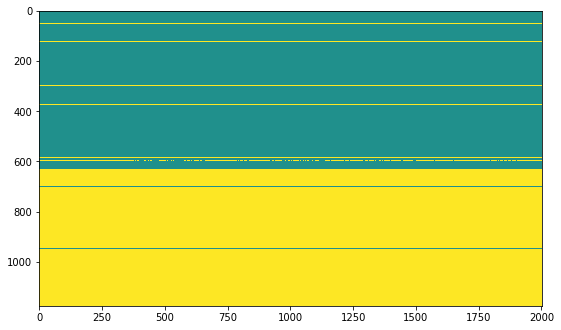

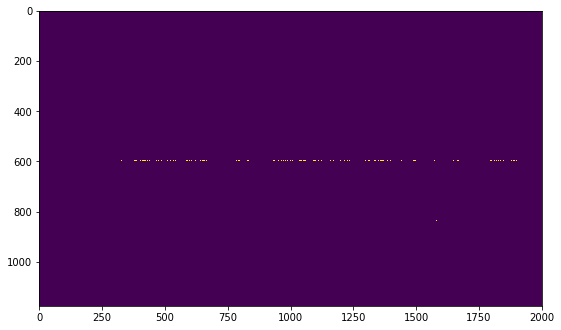

--- Correcting clustering for POPS ---


fixed 0 anomolies


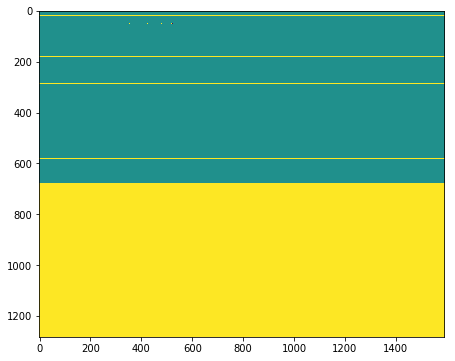

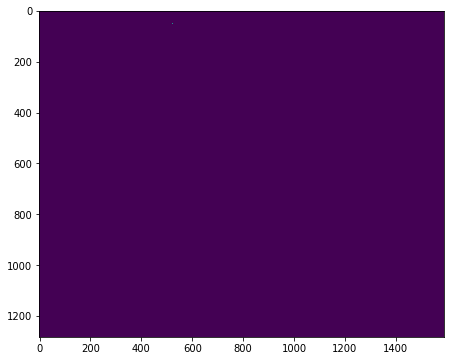

--- Correcting clustering for PIP2 ---


fixed 0 anomolies


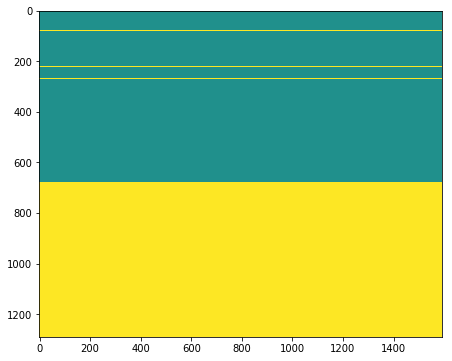

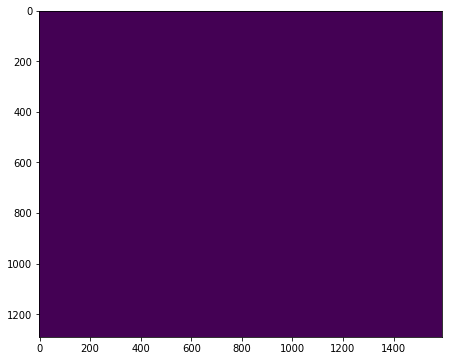

In [66]:
for system in leafletIDdict:
    print '--- Correcting clustering for %s ---'%system
    leafletIDs=leafletIDdict[system]
    transMat=(np.abs(leafletIDs[1:]-leafletIDs[:-1]))
    transCount=np.sum(transMat>0,axis=1)
    lastGoodFrame=0
    cutoff=1.*comData.shape[0]/16.
    anomolyCount=0
    for iFrame in tqdm.tqdm_notebook(np.arange(0,len(leafletIDs)-1)):
        if transCount[iFrame]>cutoff:
            anomolyCount=anomolyCount+1
            leafletIDs[iFrame+1]=leafletIDs[iFrame]
            transMat=(np.abs(leafletIDs[:-1]-leafletIDs[1:]))
            transCount=np.sum(transMat,axis=1)
    print 'fixed %g anomolies'%anomolyCount
    transMat=(np.abs(leafletIDs[1:]-leafletIDs[:-1]))
    plt.figure(figsize=(9,6))
    plt.imshow(leafletIDs.T)
    plt.show()
    plt.figure(figsize=(9,6))
    plt.imshow(transMat.T)
    plt.show()

# Saving clustering data
Now that we have fixed the anomolous frames, lets save the clustering data.

As before, we will have to break our data into chunks to make sure we are under the 20Mb limit.

Note that for the clustering arrays, the first axis corresponds to frames while the second is lipid id.
Thus we will be splitting along the first axis (axis=0).

The file size is around 40 to 50 Mb for a full array, so 3 chunks should be enough.

In [67]:
outputDir='dataFiles/leafletClustering'
dataFileTypeName='leaflet_clustering_array'
with tqdm.tqdm_notebook() as pbar:
    for system in leafletIDdict:
        dataFileNameBase='.'.join([system,dataFileTypeName])
        dataFilePathBase='/'.join([outputDir,dataFileNameBase])
        print '--- Saving clustering for %s ---'%system
        leafletIDs=leafletIDdict[system]
        saveArrayChunks(dataFilePathBase,leafletIDs,nChunks=3,axis=0,
                        pbar=pbar)
print 'DONE!'

--- Saving clustering for POPC ---
--- Saving clustering for POPS ---
--- Saving clustering for PIP2 ---
DONE!


In [124]:
np.array(np.round(np.mean(leafletIDdict[system],axis=0)),dtype=int)

array([0, 0, 0, ..., 1, 1, 1])

In [126]:
np.mean(comDataDict['POPC'],axis=1).shape

(1176, 3)